In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import seaborn as sb

In [2]:
path='/gpfs/alpine/cli900/world-shared/users/zaneb/microPhys/kessler_ml_data_flat.nc'
ds=nc.Dataset(path)

In [3]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): nsamples(24000000), three(3)
    variables(dimensions): float64 ml_in_theta(nsamples, three), float64 ml_in_qc(nsamples, three), float64 ml_in_qv(nsamples, three), float64 ml_in_qr(nsamples, three), float64 ml_in_rho_dry(nsamples, three), float64 ml_in_z(nsamples), float64 ml_in_exner(nsamples, three), float64 ml_out_theta(nsamples), float64 ml_out_qv(nsamples), float64 ml_out_qc(nsamples), float64 ml_out_qr(nsamples)
    groups: 


In [4]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'nsamples', size = 24000000
<class 'netCDF4._netCDF4.Dimension'>: name = 'three', size = 3


In [5]:
for var in ds.variables.values():
    print(var)
    

<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_theta(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qc(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qv(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qr(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_rho_dry(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_z(nsamples)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_exner(nsamples, three)
    _

In [6]:
print(ds['ml_in_theta'][1:6,])

[[300.61109288 300.61109288 301.85582406]
 [300.61109288 300.61109288 301.85582406]
 [300.61109288 300.61109288 301.85582406]
 [300.61109288 300.61109288 301.85582406]
 [300.61109288 300.61109288 301.85582406]]


In [7]:
print(np.min(ds['ml_out_qv']),np.max(ds['ml_out_qv']))
print()

7.828319084122233e-06 0.016286972793109235



In [8]:
var='ml_out_qr'
col=2

print(np.mean(ds[var]), np.std(ds[var]),np.min(ds[var]), np.max((ds[var])))

2.491729835786887e-05 0.00041271428321975755 0.0 0.020895973256408917


<AxesSubplot:>

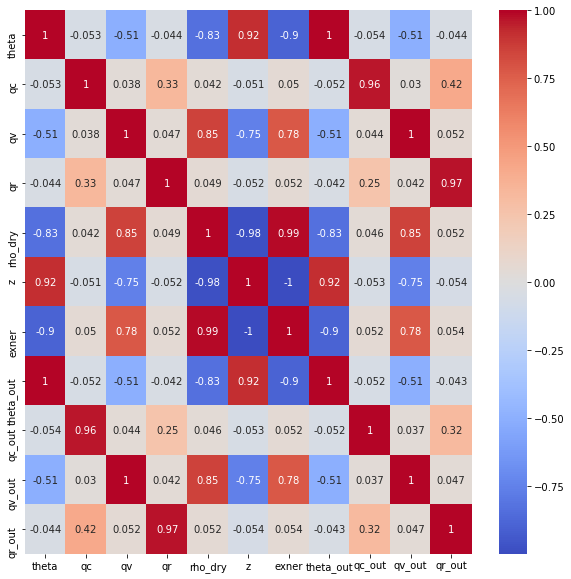

In [9]:
num1=0
num2=24000000

inputs={ 'theta': ds['ml_in_theta'][num1:num2,1],
       'qc': ds['ml_in_qc'][num1:num2,1],
       'qv': ds['ml_in_qv'][num1:num2,1],
       'qr': ds['ml_in_qr'][num1:num2,1],
       'rho_dry': ds['ml_in_rho_dry'][num1:num2,1],
       'z': ds['ml_in_z'][num1:num2],
       'exner': ds['ml_in_exner'][num1:num2,1],
       'theta_out': ds['ml_out_theta'][num1:num2],
       'qc_out': ds['ml_out_qc'][num1:num2],
       'qv_out': ds['ml_out_qv'][num1:num2],
       'qr_out': ds['ml_out_qr'][num1:num2]}

df=pd.DataFrame(inputs,columns=['theta','qc','qv','qr','rho_dry','z','exner','theta_out','qc_out','qv_out','qr_out'])

plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True, cmap='coolwarm')

In [10]:
print(df.corr())

              theta        qc        qv        qr   rho_dry         z  \
theta      1.000000 -0.053497 -0.505912 -0.043525 -0.830402  0.917968   
qc        -0.053497  1.000000  0.037600  0.333866  0.042368 -0.051043   
qv        -0.505912  0.037600  1.000000  0.046578  0.852126 -0.754595   
qr        -0.043525  0.333866  0.046578  1.000000  0.048608 -0.051834   
rho_dry   -0.830402  0.042368  0.852126  0.048608  1.000000 -0.981761   
z          0.917968 -0.051043 -0.754595 -0.051834 -0.981761  1.000000   
exner     -0.895436  0.049731  0.780281  0.051801  0.990237 -0.998527   
theta_out  0.999997 -0.051733 -0.505865 -0.042464 -0.830391  0.917952   
qc_out    -0.053759  0.962126  0.043958  0.253745  0.045585 -0.053017   
qv_out    -0.505792  0.030075  0.999955  0.042369  0.852115 -0.754512   
qr_out    -0.044225  0.416287  0.052149  0.971785  0.051632 -0.054208   

              exner  theta_out    qc_out    qv_out    qr_out  
theta     -0.895436   0.999997 -0.053759 -0.505792 -0.044225

(array([1.78116311e+03, 1.62930610e+02, 1.23598587e+02, 7.67300796e+01,
        3.76161266e+01, 5.62964702e+01, 6.06763074e+01, 1.88421048e+01,
        3.29677965e+01, 3.75209127e+01, 2.06460490e+01, 4.68580131e+01,
        1.11942824e+01, 1.72326835e+01, 4.69025486e+01, 6.87459374e+00,
        1.07351059e+01, 1.69905537e+01, 4.27960673e+01, 3.70822123e+00,
        8.77579938e+00, 1.10837115e+01, 1.86396474e+01, 3.51810067e+01,
        1.92654481e+00, 4.71999639e+00, 1.03560422e+01, 1.21369508e+01,
        2.27778667e+01, 2.42109375e+01, 9.05555406e-01, 1.69106969e+00,
        4.47991415e+00, 1.04837618e+01, 1.40660551e+01, 4.46854992e+01,
        1.46404096e+00, 9.21680333e-01, 9.63400381e-01, 1.68671852e+00,
        9.98004985e+00, 2.74617739e+01, 1.59586096e+02, 2.66388908e+01,
        1.21525638e+00, 1.10724496e+00, 8.12645114e-01, 5.97134189e-01,
        4.58920532e-01, 1.20041121e-01]),
 array([7.82831908e-06, 3.33411209e-04, 6.58994098e-04, 9.84576988e-04,
        1.31015988e-03

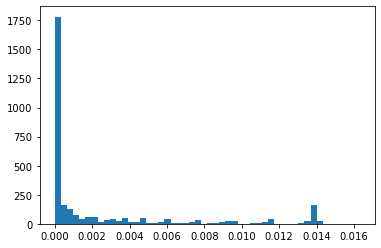

In [11]:
plt.hist(ds['ml_out_qv'][0:23999999],bins=50, density=True)

<AxesSubplot:xlabel='z', ylabel='qr_out'>

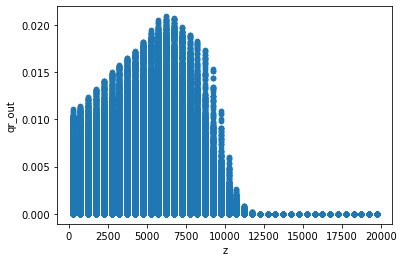

In [17]:
df.plot.scatter(x='z',y='qr_out')

In [18]:
normDF=(df-df.mean())/df.std()

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

x=normDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y=normDF[['theta_out','qc_out','qv_out','qr_out']].copy()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=27)

In [20]:
letters=['a','b','c','d','e']

for i in range(10):
    print(np.random.choice(letters))

b
d
d
a
d
a
e
a
a
b


In [16]:
reg=MLPRegressor(hidden_layer_sizes=[64,64],activation='relu', solver='adam',learning_rate_init=1e-4,learning_rate='constant', max_iter=250, early_stopping=True, verbose=True)
reg.fit(xtrain,ytrain)


Iteration 1, loss = 0.00834338
Validation score: 0.989479
Iteration 2, loss = 0.00491850
Validation score: 0.990738
Iteration 3, loss = 0.00443658
Validation score: 0.991584
Iteration 4, loss = 0.00406332
Validation score: 0.992119
Iteration 5, loss = 0.00380014
Validation score: 0.992478
Iteration 6, loss = 0.00358443
Validation score: 0.993140
Iteration 7, loss = 0.00343840
Validation score: 0.992859
Iteration 8, loss = 0.00330625
Validation score: 0.993406
Iteration 9, loss = 0.00317536
Validation score: 0.993909
Iteration 10, loss = 0.00305840
Validation score: 0.993508
Iteration 11, loss = 0.00293294
Validation score: 0.994387
Iteration 12, loss = 0.00280186
Validation score: 0.994354
Iteration 13, loss = 0.00268096
Validation score: 0.994885
Iteration 14, loss = 0.00256309
Validation score: 0.994491
Iteration 15, loss = 0.00246370
Validation score: 0.994966
Iteration 16, loss = 0.00237283
Validation score: 0.995331
Iteration 17, loss = 0.00228446
Validation score: 0.995663
Iterat

MLPRegressor(early_stopping=True, hidden_layer_sizes=[64, 64],
             learning_rate_init=0.0001, max_iter=250, verbose=True)

In [21]:
from sklearn.metrics import r2_score

ypred=reg.predict(xtest)
plt.plot(reg.loss_curve_)

print('# of Iterations:',reg.n_iter_,'-----','Final Training Loss=',reg.loss_)
print('R^2 test scores ----- AVG=',reg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypred,multioutput='raw_values') )


NameError: name 'reg' is not defined

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

regTree= DecisionTreeRegressor(random_state=1, criterion='mae')
regTree.fit(xtrain,ytrain)

#regRF= RandomForestRegressor(random_state=0)
#regRF.fit(xtrain,ytrain)


In [ ]:
from sklearn.metrics import r2_score

ypredTree=regTree.predict(xtest)
#ypredRF=regRF.predict(xtest)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',regTree.n_features_,'-----','# outputs:',regTree.n_outputs_)
print('R^2 test scores ----- AVG=',regTree.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredTree,multioutput='raw_values') )

"""
print(-----------------------------Random Forrest Results------------------------)
print('# features:',regRF.n_features_,'-----','# outputs:',regRF.n_outputs_)
print('R^2 test scores ----- AVG=',regRF.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredRF,multioutput='raw_values') )
"""

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
KNR = KNeighborsRegressor(n_neighbors=5)
KNR.fit(xtrain, ytrain)

ypredKNR=KNR.predict(xtest)
print('Metric Used:',KNR.effective_metric_,'-----','# samples:',KNR.n_samples_fit_)
print('R^2 test scores ----- AVG=',KNR.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredKNR,multioutput='raw_values') )

In [ ]:
"""
Measuring number of no-op samples

ml_in_theta(isample,1) == ml_out_theta(isample) &&
ml_in_qv   (isample,1) == ml_out_qv   (isample) && 
ml_in_qc   (isample,1) == ml_out_qc   (isample) &&
ml_in_qr   (isample,1) == ml_out_qr   (isample)
"""
count=0

for i in range(24000000):
    if ds['ml_in_theta'][i,1]==ds['ml_out_theta'][i] and ds['ml_in_qv'][i,1]==ds['ml_out_qv'][i] and ds['ml_in_qc'][i,1]==ds['ml_out_qc'][i] and ds['ml_in_qr'][i,1]==ds['ml_out_qr'][i]:
         count+=1
          


In [ ]:
print('% of no-op data=',(count/24000000)*100)